# ImageBind demonstration

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagebind/pytorch/huge/1/imagebind_huge.pth


In [2]:
!git clone https://github.com/Tmqng/ImageBind.git
%cd ImageBind
!pip install .

Cloning into 'ImageBind'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 223 (delta 104), reused 88 (delta 63), pack-reused 60 (from 3)
Receiving objects: 100% (223/223), 3.96 MiB | 21.82 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/kaggle/working/ImageBind
Processing /kaggle/working/ImageBind
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 6cdc929315aab1b5674b6dcf73b16ec99147735f) to /tmp/pip-install-0nmesiji/pytorchvideo_da848022483c4bc3b8818c162483ef07
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-0nmesiji/pytorchvideo_da848022483c4bc3b8818c162483ef07
  Running command git rev-parse -q --verify 'sha^6cdc929315aab1b5674b6dcf73b16ec99147735f'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git

In [3]:
!git pull

Already up to date.


In [4]:
import sys 
sys.path.append("/kaggle/working/ImageBind/") 
import imagebind
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

!mkdir /kaggle/working/.checkpoints
!ln -s /kaggle/input/imagebind/pytorch/huge/1/imagebind_huge.pth /kaggle/working/.checkpoints/imagebind_huge.pth

!mkdir /kaggle/working/bpe
!ln -s /kaggle/working/ImageBind/bpe/bpe_simple_vocab_16e6.txt.gz /kaggle/working/bpe/bpe_simple_vocab_16e6.txt.gz

!mkdir /kaggle/working/.assets
!ln -s /kaggle/working/ImageBind/.assets /kaggle/working/.assets

model = imagebind_model.imagebind_huge(pretrained=True)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

100%|██████████| 4.47G/4.47G [00:14<00:00, 335MB/s] 


In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [6]:
text_list=["A dog.", "A car", "A bird", "A piano"]
image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg", ".assets/piano_image.jpg"]
audio_paths=[".assets/dog_audio.wav", ".assets/car_audio.wav", ".assets/bird_audio.wav", ".assets/piano_audio.wav"]

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

print(
    "Vision x Text: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Audio x Text: ",
    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Vision x Audio: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1),
)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Vision x Text:  tensor([[9.9761e-01, 2.3694e-03, 1.8613e-05, 1.1449e-07],
        [3.3833e-05, 9.9984e-01, 2.4116e-05, 1.0692e-04],
        [4.7996e-05, 1.3496e-02, 9.8645e-01, 3.8887e-06],
        [2.6889e-09, 7.4278e-07, 8.6335e-08, 1.0000e+00]], device='cuda:0')
Audio x Text:  tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')
Vision x Audio:  tensor([[0.7548, 0.1018, 0.0788, 0.0647],
        [0.0967, 0.7359, 0.1007, 0.0666],
        [0.0018, 0.0022, 0.9950, 0.0010],
        [0.0165, 0.2635, 0.0683, 0.6517]], device='cuda:0')


## Plot embeddings in common space (2D and 3D). 
[In progress] t-SNE and UMAP lose a lot of information from dimension 1024 to 3.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import umap

2026-01-31 15:12:30.512546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769872351.050654      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769872351.199825      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769872352.517825      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769872352.517861      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769872352.517864      55 computation_placer.cc:177] computation placer alr

In [53]:
def plot_imagebind_2d(embeddings_dict, concept_labels=None):
    all_vecs = []
    modality_names = []
    
    # 1. Normalize and collect data
    for mod, emb in embeddings_dict.items():
        # L2 Normalization is crucial for Cosine Similarity space
        norm_emb = F.normalize(emb, p=2, dim=-1).cpu().numpy()
        all_vecs.append(norm_emb)
        modality_names.extend([str(mod).split('.')[-1]] * norm_emb.shape[0])
        
    data_stack = np.vstack(all_vecs)
    
    # 2. Reduce dimensions (t-SNE)
    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca')
    low_dim_data = tsne.fit_transform(data_stack)
    
    # 3. Plotting
    plt.figure(figsize=(10, 7))
    unique_modalities = list(set(modality_names))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_modalities)))
    
    for i, mod in enumerate(unique_modalities):
        mask = np.array([m == mod for m in modality_names])
        plt.scatter(low_dim_data[mask, 0], low_dim_data[mask, 1], label=mod, s=100, alpha=0.8)
        
        # Optional: Label individual points if labels are provided
        if concept_labels:
            for j, label in enumerate(concept_labels):
                plt.annotate(label, (low_dim_data[mask][j, 0], low_dim_data[mask][j, 1]))

    plt.title("ImageBind Shared Embedding Space (2D Projection)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.savefig('my_embeddings_plot.png')
    plt.show()

    return low_dim_data

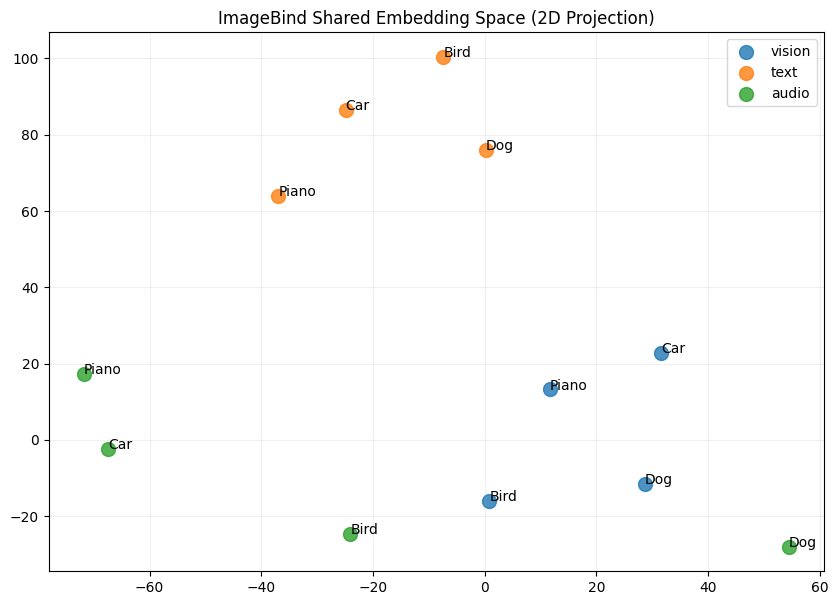

[[  0.15898216  75.993675  ]
 [-24.886747    86.56968   ]
 [ -7.3712277  100.41098   ]
 [-36.97613     64.02129   ]
 [ 28.676086   -11.5138855 ]
 [ 31.539028    22.858446  ]
 [  0.8420225  -16.011026  ]
 [ 11.642631    13.227105  ]
 [ 54.43437    -28.000212  ]
 [-67.380585    -2.306851  ]
 [-24.077782   -24.57011   ]
 [-71.72663     17.213655  ]]


In [54]:
labels = ["Dog", "Car", "Bird", "Piano"]
embeddings_2d = plot_imagebind_2d(embeddings, concept_labels=labels)
print(embeddings_2d)

In [47]:
def plot_imagebind_3d_umap(embeddings_dict, concept_labels=None):
    all_vecs = []
    modality_names = []
    
    # 1. Normalize and collect data
    # We use L2 normalization because ImageBind uses Cosine Similarity
    for mod, emb in embeddings_dict.items():
        norm_emb = F.normalize(emb, p=2, dim=-1).cpu().numpy()
        all_vecs.append(norm_emb)
        # Extract name from ModalityType enum (e.g., 'VISION')
        mod_name = str(mod).split('.')[-1]
        modality_names.extend([mod_name] * norm_emb.shape[0])
        
    data_stack = np.vstack(all_vecs)
    
    # 2. Dimensionality Reduction (UMAP 3D)
    # n_neighbors: balances local vs global structure (usually 5-50)
    # min_dist: how tightly points cluster (0.1 is standard)
    reducer = umap.UMAP(
        n_components=3, 
        n_neighbors=min(len(data_stack)-1, 15), 
        min_dist=0.1, 
        random_state=42
    )
    embeddings_3d = reducer.fit_transform(data_stack)
    
    # 3. 3D Plotting
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_modalities = sorted(list(set(modality_names)))
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(unique_modalities)))
    
    for i, mod in enumerate(unique_modalities):
        mask = np.array([m == mod for m in modality_names])
        xs = embeddings_3d[mask, 0]
        ys = embeddings_3d[mask, 1]
        zs = embeddings_3d[mask, 2]
        
        ax.scatter(xs, ys, zs, label=mod, s=100, alpha=0.7, edgecolors='white')
        
        # 4. Annotate Concepts
        if concept_labels:
            # Assumes concept_labels length matches number of samples per modality
            for j, label in enumerate(concept_labels):
                if j < len(xs):
                    ax.text(xs[j], ys[j], zs[j], label, size=9, zorder=1, color='black')

    ax.set_title("ImageBind 3D UMAP: Multimodal Semantic Alignment")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_zlabel("UMAP 3")
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('imagebind_3d_umap.png')
    plt.show()

    return embeddings_3d

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_55/3694944060.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(unique_modalities)))


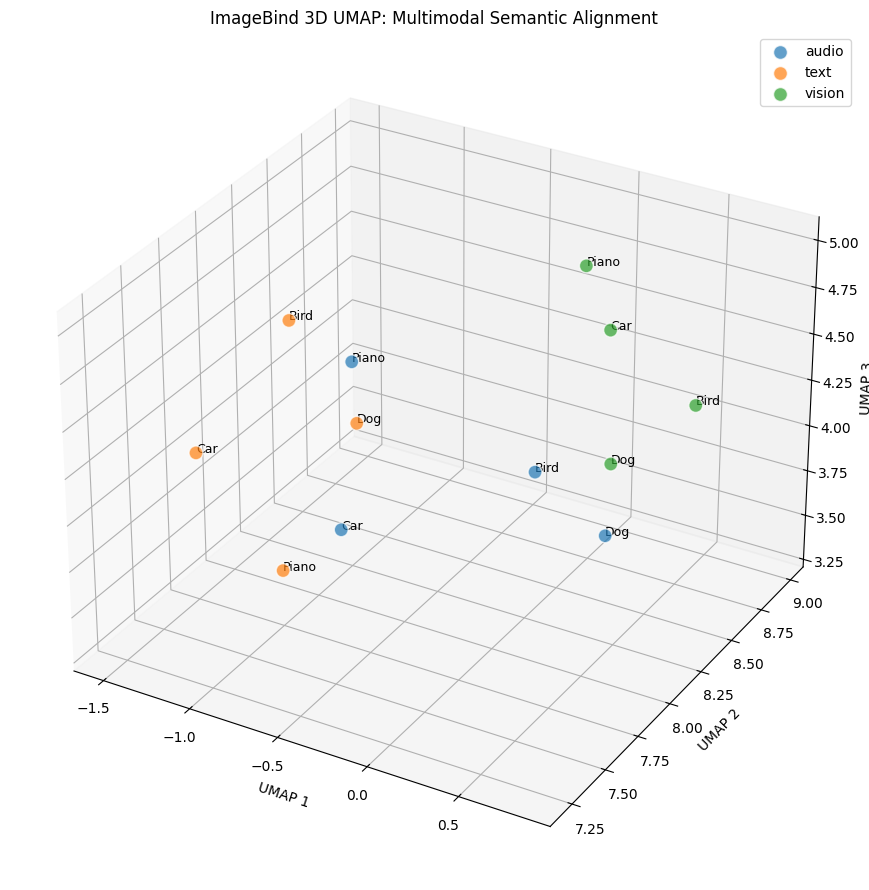

[[-1.0806184   8.392979    3.8947906 ]
 [-1.5038866   7.7592793   4.013743  ]
 [-1.1845727   8.045529    4.6402917 ]
 [-0.85753345  7.5780416   3.6719956 ]
 [ 0.30724785  8.484615    3.9960072 ]
 [-0.05212233  8.981542    4.326033  ]
 [ 0.82178074  8.395844    4.508646  ]
 [ 0.10851455  8.546531    4.9676285 ]
 [ 0.07219668  8.791353    3.328781  ]
 [-0.2305406   7.2175355   4.313919  ]
 [ 0.5583197   7.5482526   4.6223783 ]
 [-0.348002    7.448722    5.00191   ]]


In [52]:
labels = ["Dog", "Car", "Bird", "Piano"]
embeddings_3d = plot_imagebind_3d_umap(embeddings, concept_labels=labels)
print(embeddings_3d)